# Fitting tranists using MCMC

This guide shows how to fit transits using a fairly uncommon technique. Typically this fitting process is done using the enitre light curve (unfolded). In this notebook, I perform folding and binning before fitting the transit. If you are having trouble fitting a transit using the traditional method (no binning and folding), this program can probably help you to obtain good initial estimates on some unknown parameters. 


Advantages to folding & binning before fitting are:
* Less data points (>1000 times faster solving, ~1 min vs >24 hours)
* Less free variables to solve for, so better accuracy in results

Disadvantages:
* No error estimation on t0 or period since its required to be known beforehand during folding
* requires knowing an accurate period and t0 beforehand.



The parameters we solve for in this notebook are:
* radius ratio
* limb darkening coefficents (u1, u2)
* inclination angle
* semi-major axis (not direectly solved, is calculated from the other solved params)


Params that need to be known to use this program:
* stellar mass
* stellar radius
* orbital period
* t0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import exoplanet as xo
import pymc3 as pm
from copy import deepcopy
from astropy.constants import R_sun, M_sun, R_earth, M_earth
cdir = os.getcwd()
os.chdir('/media/rd1/kwillis/class_rv_lc')
from kepler_utils import phase_fold_time, global_view
os.chdir(cdir)
import corner
import pymc3_ext as pmx

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%matplotlib notebook

#%matplotlib inline

In [4]:
def bjd2bkjd(bjd):
    
    return bjd - 2454833.0


def bkjd2bjd(bkjd):
    
    return bkjd + 2454833.0


def mask_transits(t0_bkjd, period_day, duration_day, time_bkjd, flux, 
                  lc=None, return_index=True):
   
    # http://www.raa-journal.org/docs/Supp/ms4253tab1.txt
       
    if lc != None:
        
        time_bkjd = np.array(lc.astropy_time.value)

        flux = lc.flux
   
    t0f_bkjd = np.copy(t0_bkjd)
      
    tots_bkjd = get_transit_times(t0f_bkjd, period_day, duration_day, time_bkjd, flux)
   
    # For each tranist find all datapoints within the tranist duration window
   
    ntot_idx = np.ones(len(flux), dtype=bool)
   
    for tot in tots_bkjd:
       
        tot_idx = (time_bkjd > tot - duration_day / 2) & (time_bkjd < tot + duration_day / 2)
       
        ntot_idx = ntot_idx & ~tot_idx
    
    if return_index:
        return ~ntot_idx # Returns where transits occur
    else:
        return time_bkjd[ntot_idx], flux[ntot_idx]
    
    
def get_transit_times(t0_bkjd, period_day, duration_day, time_bkjd, flux):
    
    t0f_bkjd = np.copy(t0_bkjd)
   
    while t0f_bkjd > time_bkjd[0]:
       
        t0f_bkjd -= period_day
        
    #t0f_bkjd += period_day
        
    while t0f_bkjd < time_bkjd[0]:
       
        t0f_bkjd += period_day
        
    #t0f_bkjd -= period_day
       
    return np.arange(t0f_bkjd, time_bkjd.max(), step=period_day)


# Folding and binning functions

def signal(time_array, flux, period_id, t0=0.0, num_bins=2000):
    
    # fold and bin transit
    
    time_array = phase_fold_time(time_array, period_id, t0)
    sorted_i = np.argsort(time_array)
    time_array = time_array[sorted_i]
    flux = flux[sorted_i]

    global_view0 = global_view(time_array, flux, period_id, num_bins=num_bins)
    
    t = np.linspace(np.min(time_array), np.max(time_array), num_bins)

    return t, global_view0


def signal_no_bin(time_array, flux, period_id, t0):

    time_array = phase_fold_time(time_array, period_id, t0)
    sorted_i = np.argsort(time_array)
    time_array = time_array[sorted_i]
    flux = flux[sorted_i]

    return time_array, flux


def create_mcmc_model(t, f, ferr, pm, ig, enable_lc_log=False, optimize_q=True):
    
    import pymc3 as pm

    with pm.Model() as model:

        # The baseline flux
        #mean = pm.Normal("mean", mu=ig['cont'], sd=ig['cont_sd'])
        
        t0 = ig['t0']
        
        period = ig['P']
        
        # quadratic limb darkening paramters
        u1 = pm.Uniform('u1', 
                         lower=ig['u1_lb'],
                         upper=ig['u1_ub'],
                         shape=1, 
                         testval=np.array([ig['u1']]))
        
        u2 = pm.Uniform('u2', 
                         lower=ig['u2_lb'],
                         upper=ig['u2_ub'],
                         shape=1, 
                         testval=np.array([ig['u2']]))
        
        u = pm.math.concatenate([u1, u2])

        
        # radius ratio rplanet/rstar
        rr = pm.Uniform("r_ratio", lower=ig['r_ratio_lb'], upper=ig['r_ratio_ub'], shape=1, testval=np.array([ig['r_ratio_sv']]))
        
        
        # orbit plane inclinatation
        incl = pm.Uniform("incl", lower=ig['incl_lb'], 
                       upper=ig['incl_ub'], 
                       shape=1, 
                       testval=np.array([ig['incl_sv']]))
        
        
        # Star 1 radius
        R1 = ig['r_star']
        
        
        # planet radius
        R2 = pm.Deterministic("R2", rr * R1)
        
        # Set up a Keplerian orbit for the planets
        orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, incl=incl, r_star=R1, m_star=ig['m_star'])
        
        pm.Deterministic("a", orbit.a)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=R2, t=t)
        
        light_curve = pm.math.sum(light_curves, axis=-1) + ig['cont']

        # Here we track the value of the model light curve for plotting purposes
        if enable_lc_log:
            pm.Deterministic("light_curves", light_curves)

        # In this line, we simulate the dataset that we will fit
        sim = xo.eval_in_model(light_curve)

        # The likelihood function assuming known Gaussian uncertainty
        pm.Normal("obs", mu=light_curve, sd=ferr, observed=f)

        
        ############################################################################
        # Optimize
        
        map_soln = model.test_point
        
        if optimize_q:

            map_soln = pmx.optimize(map_soln, [incl])
            map_soln = pmx.optimize(map_soln, [u1, u2])
            map_soln = pmx.optimize(map_soln, [incl])
            map_soln = pmx.optimize(map_soln)

            
    return model, pm, map_soln, sim


def plot_pre_mcmc(t, f, ferr, map_soln):
    
    # for plotting after optimization
    
    per = ig["P"]
    t0 = ig["t0"]

    plt.figure(figsize=(7, 5))
    plt.plot(t, f-1, ".k", ms=4, label="data")

    #if len(t0s) == 1:
    for i, l in enumerate("a"):
        plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
    plt.xlim(t.min(), t.max())
    plt.ylabel("relative flux")
    plt.xlabel("time [days]")
    plt.legend(fontsize=10)
    plt.title("map model")

# Load saved normalized light curve data

You probably wont save data in the same way that I have here, so you will need to edit this cell to load your data properly.

Things you should save when you save your data:
* time
* normalized flux
* flux error
* t0
* orbital period
* transit duration

In [5]:
###########  User Params  #############

target_name = '11904151'

#######################################

lc_data_dir = opj('/media/rd1/kwillis/light_curve_routines/data/norm_lcs', target_name + '_LC_data.npz')

lc_lf = np.load(lc_data_dir)


data = {'lc_flux': lc_lf['flux_norm'], 
        'lc_flux_err': lc_lf['flux_err_norm'],
        'lc_time': lc_lf['time_norm'],
       }

len(data['lc_time']), lc_lf['t0_pri_day'], lc_lf['p_day'], lc_lf['d_day']

(1405033,
 array([2454964.574858, 2454971.678725]),
 array([ 0.83749122, 45.29422297]),
 array([0.11225 , 0.426875]))

# Fold and bin the light curve using the best t0 and period you found elsewhere

<IPython.core.display.Javascript object>


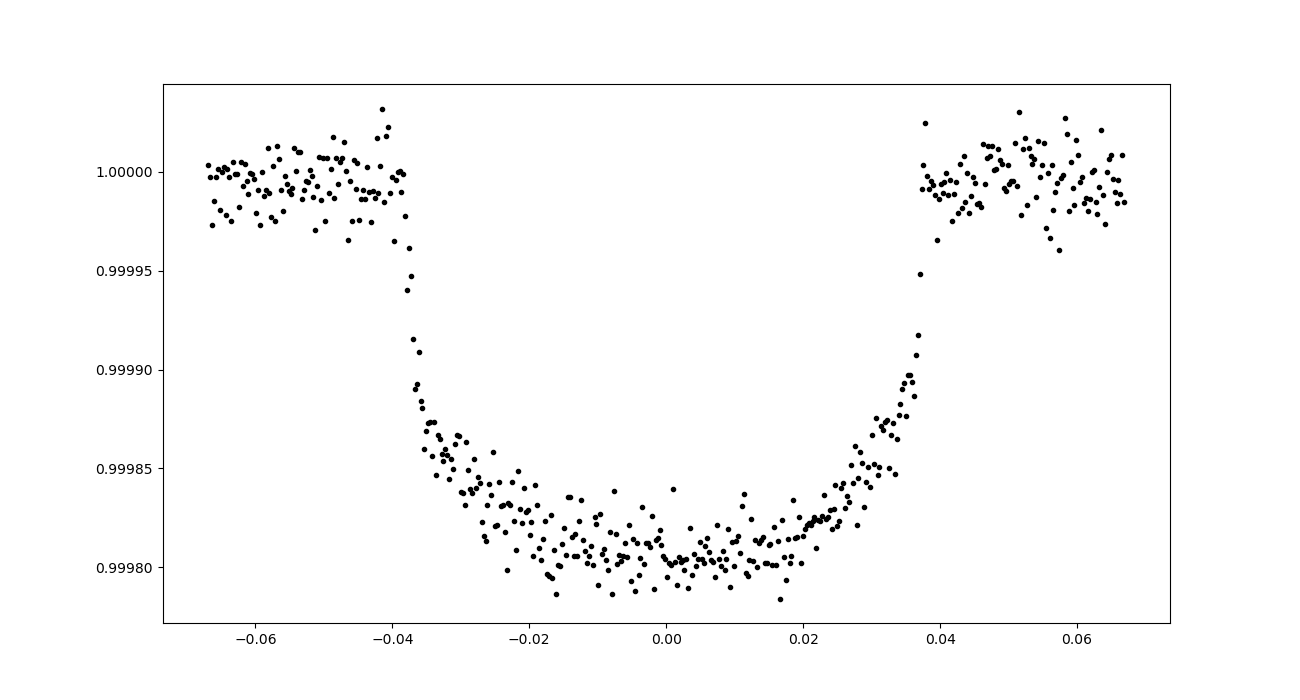

(480, 480, 480)

In [8]:
###########  User Params  #############

bincnt = 3000    # How many bins in your fold. Note that the output will be smaller than this, since we will crop the fold using the param below

fold_edge_crop_pct = 42   # Percent of datapoints to crop out at the left and right edge. Example: 30% crop with a bincnt of 10 --> [YYYNNNNYYY] --> [NNNN] so, final output LC would hav 4 datapoints

#######################################


# Fold then bin
t_fold, f_fold = signal(np.array(lc_lf['time_norm']), np.array(lc_lf['flux_norm']), lc_lf['p_day'][0], t0=lc_lf['t0_pri_day'][0], num_bins=bincnt)

# Fold error
t_fold, fe_fold = signal(np.array(lc_lf['time_norm']), np.array(lc_lf['flux_err_norm']), lc_lf['p_day'][0], t0=lc_lf['t0_pri_day'][0], num_bins=bincnt)

l_idx = int(np.ceil(len(t_fold) * fold_edge_crop_pct / 100))

data = {'lc_flux': f_fold[l_idx:-l_idx], 
        'lc_flux_err': fe_fold[l_idx:-l_idx] / 100,
        'lc_time': t_fold[l_idx:-l_idx],
       }



plt.figure(figsize=(13,7))
plt.plot(data['lc_time'], data['lc_flux'], '.k')


len(data['lc_time']), len(data['lc_flux']), len(data['lc_flux_err'])

# If required, do some unit conversions and calulations to derive some fitting parameters

Here I needed to convert some radius values and calculate a radius ratio estimate

R_sun and R_earth are constants loaded from astropy, in unit meters

In [11]:
R1_est = 1.48e9 / R_sun.value / 2
R2_est = 1.47 * (R_earth / R_sun).value
r_ratio_est = R2_est / R1_est

R1_est, R2_est, r_ratio_est, 1/r_ratio_est

(1.0636768722150352,
 0.013476796032772747,
 0.012670009459459461,
 78.9265393368272)

# State your intial guesses and solving bounds

lb & ub are lower and upper bound. Make sure that your starting value is between these bounds!

In [19]:
###########  User Params  #############
    
ig = {'cont':               1.0,                   # Continuum level
      't0':                 0.0,                   # t0 [day]
      'P':                  0.837491225,           # period [day]
      'u2':                 0.0,                   # Limb darkening param - edge curvature 
      'u2_lb':              -1.0,
      'u2_ub':              2.0, 
      'u1':                 0.0,                    # Limb darkening param - edge curvature 
      'u1_lb':              -1.0,
      'u1_ub':              2.0,
      'incl_sv':            89.0 / 180 * np.pi,    # orbit inclination [rad]
      'incl_lb':            80.0 / 180 * np.pi,  
      'incl_ub':            90.0 / 180 * np.pi,  
      'r_ratio_sv':         0.01267,               # radius ratio (r_planet / r_star) - depth of transit
      'r_ratio_lb':         0.000,                 
      'r_ratio_ub':         1.000,                 
      'r_star':             R1_est,                # radius of primary star [R_sun]
      'm_star':             0.92,                  # mass of primary star [M_sun]
     }

# Create orbit model and optimize your parameters

optimizing logp for variables: [incl]


message: Optimization terminated successfully.
logp: -65570.88964918542 -> -24405.978018138798
optimizing logp for variables: [u2, u1]


message: Optimization terminated successfully.
logp: -24405.978018138798 -> -5216.287139317207
optimizing logp for variables: [incl]


message: Optimization terminated successfully.
logp: -5216.287139317207 -> -3761.8357553527026
optimizing logp for variables: [incl, r_ratio, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -3761.8357553527026 -> -3340.0319421494833


<IPython.core.display.Javascript object>


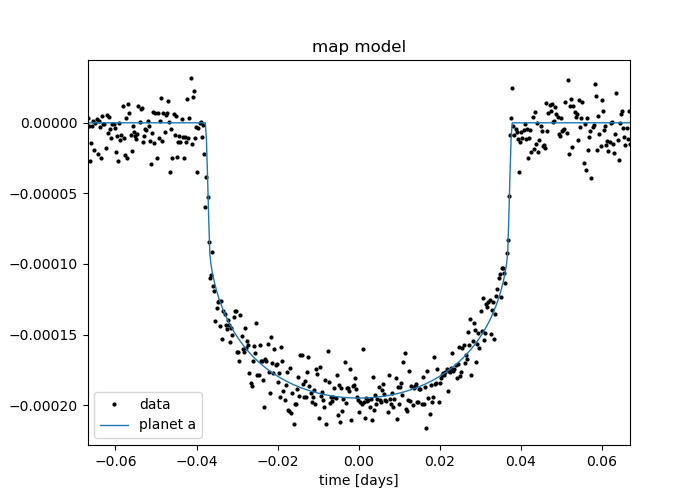

In [20]:
model, pm, map_soln, f_sim = create_mcmc_model(data['lc_time'], data['lc_flux'], data['lc_flux_err'], pm, ig, enable_lc_log=1, optimize_q=1)

plot_pre_mcmc(data['lc_time'], data['lc_flux'], data['lc_flux_err'], map_soln)

# Run MCMC on your orbit model

Params you can change:
* tune: how many samples per chain to get MCMC algo in tune with your data. I set a very high value (3000), but could probably get same results with 300.
* draws: how many samples per chain to try. Basically how many fits the algo will attempt. THe more you have, the better. However, too many past a certain point does you no good. Some difficult problems may require 30k draws, while easy ones can be done in <1000. Typically, these fits will need at least 3000 to look good in the corner plot and get good error estimates.
* chains: should be at least as big as the number of variables you are solving for. Think of chaings like the number of time syou will try to solve the system with N "draws". When all chains, which solve in parallel, are converging in on the same answer, the MCMC algo is happy.

In [21]:
np.random.seed(42)

with model:
    
    trace = pm.sample(tune=200,
                      draws=3000,
                      start=map_soln,
                      chains=6,
                      init="adapt_full",
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (6 chains in 4 jobs)
NUTS: [incl, r_ratio, u2, u1]


Sampling 6 chains for 200 tune and 3_000 draw iterations (1_200 + 18_000 draws total) took 31 seconds.
The acceptance probability does not match the target. It is 0.9915680038798524, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9891861441186719, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9919857795200778, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9914641106673683, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9926858957221785, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9848253887361423, but should be close to 0.9. Try to increase the number of

# Show a summary of the solved parameters

In [22]:
mcmc_summary = pm.summary(trace, kind='stats')

mcmc_summary

/opt/anaconda/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
u1[0],0.463,0.011,0.442,0.485
u2[0],0.188,0.017,0.157,0.219
r_ratio[0],0.013,0.000,0.013,0.013
incl[0],1.469,0.000,1.469,1.469
R2[0],0.014,0.000,0.014,0.014
...,...,...,...,...
"light_curves[475,0]",0.000,0.000,0.000,0.000
"light_curves[476,0]",0.000,0.000,0.000,0.000
"light_curves[477,0]",0.000,0.000,0.000,0.000
"light_curves[478,0]",0.000,0.000,0.000,0.000


<IPython.core.display.Javascript object>


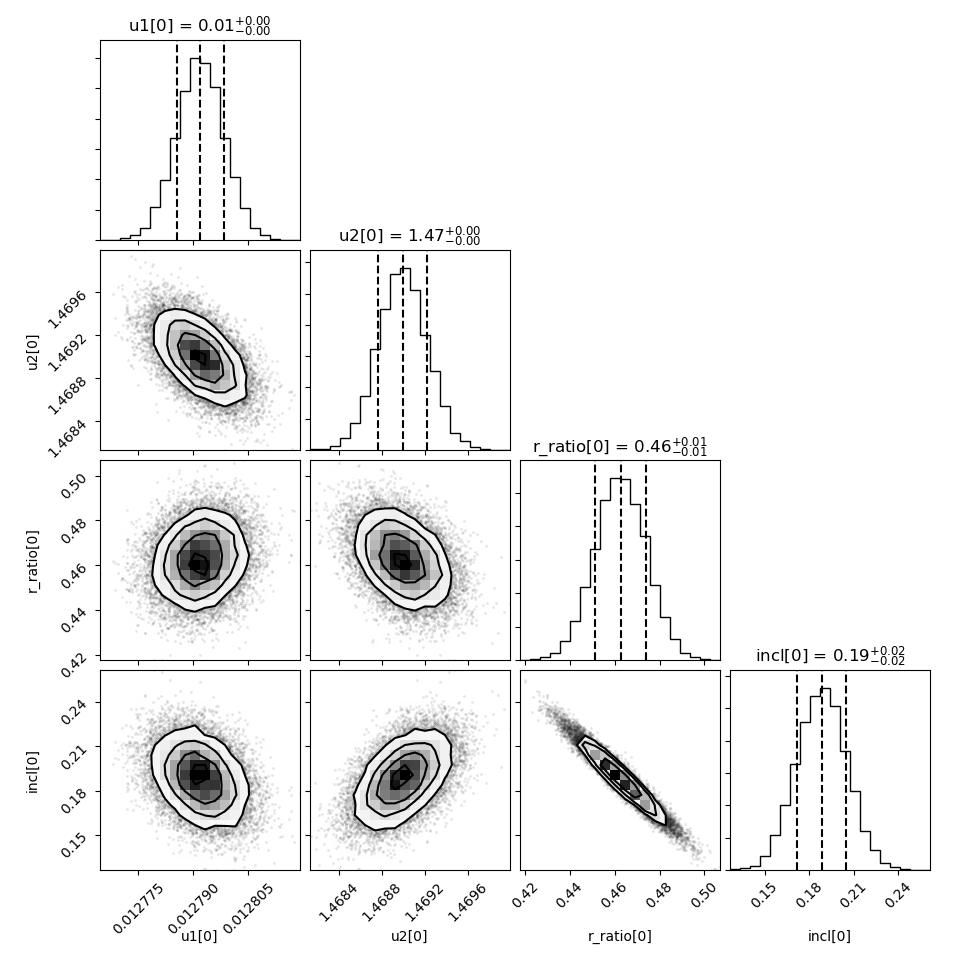

In [23]:
flat_samples = np.copy(pm.trace_to_dataframe(trace, varnames=['r_ratio', 'incl', 'u1', 'u2']))

fig = corner.corner(flat_samples, 
                    labels=mcmc_summary.index.to_numpy(),
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    #fig=fig,
                    #title_kwargs={"fontsize": fontsize}, 
                    #label_kwargs={"fontsize": fontsize}
                   );

# Make final plot showing the fit from the optimizer (LSE) and MCMC (MLE)

<IPython.core.display.Javascript object>


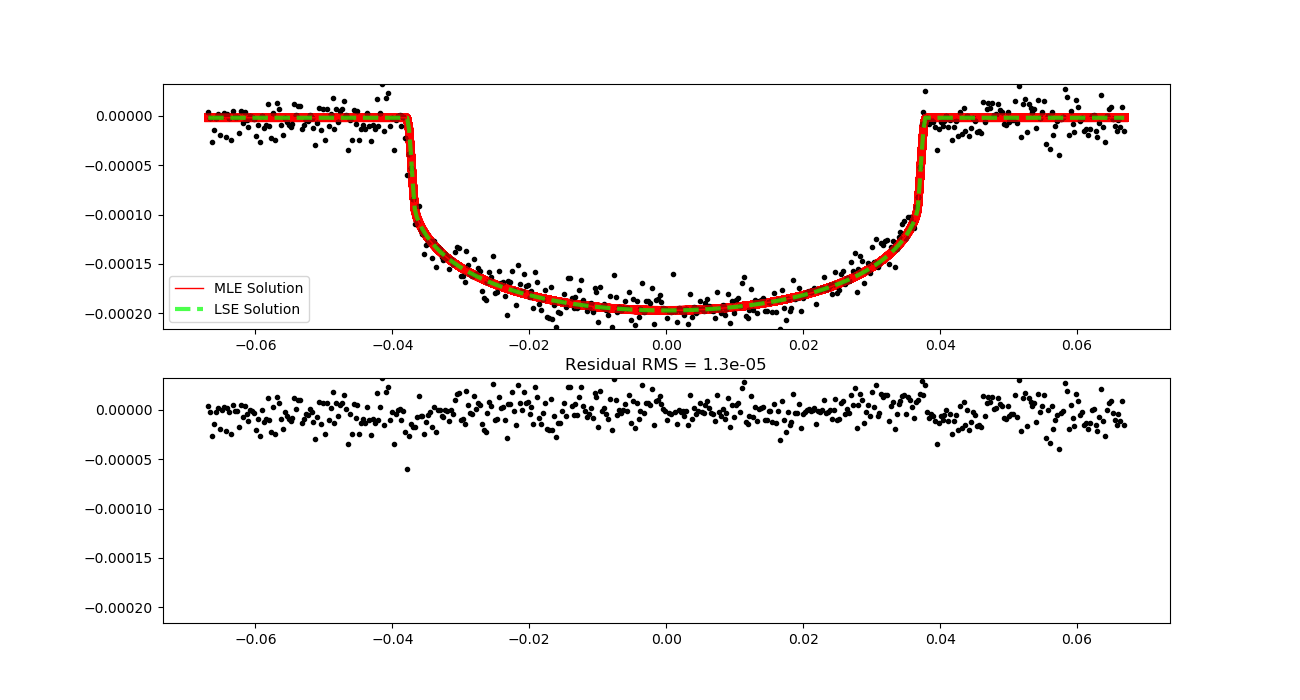

In [24]:
trace_lcs = np.copy(pm.trace_to_dataframe(trace, varnames=['light_curves']))


plt.figure(figsize=(13,7))

ax = plt.subplot(2, 1, 1)
plt.plot(data['lc_time'], data['lc_flux'] - 1, '.k')

# plot 2000 random light curves from the MCMC trace. Gives you a good visual of the error in the fit.
sample_cnt = 2000
if sample_cnt > trace_lcs.shape[0]:
    sample_cnt = trace_lcs.shape[0] - 10
for trace_lc in trace_lcs[np.random.choice(np.arange(trace_lcs.shape[0]), 2000)]:
    
    plt.plot(data['lc_time'], trace_lc - 1 + np.median(data['lc_flux'] - trace_lc), '-r', alpha=0.01, lw=6)
    
# plot the average light curve fit from MCMC
mle_lc = np.nanmedian(trace_lcs, axis=0)
plt.plot(data['lc_time'], mle_lc - 1 + np.median(data['lc_flux'] - mle_lc), '-r', label='MLE Solution', lw=1, alpha=1.0)
plt.plot(data['lc_time'], np.ravel(map_soln['light_curves']) - 1 + np.median(data['lc_flux'] - np.ravel(map_soln['light_curves'])), '--', c=[0, 1, 0], label='LSE Solution', lw=3, alpha=0.7)
plt.legend()
plt.ylim(np.min(data['lc_flux'] - 1), np.max(data['lc_flux'] - 1))

plt.subplot(2, 1, 2, sharex=ax, sharey=ax)
df = (data['lc_flux'] - mle_lc) - 1
plt.title('Residual RMS = ' + str(np.around(np.std(df), 6)))
plt.plot(data['lc_time'], df, '.k');